<a href="https://colab.research.google.com/github/flohmannjr/tensorflow_curso/blob/main/TensorFlow_TL4_Outros_Modelos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TensorFlow Tranfer Learning Teste de Modelos

In [1]:
import tensorflow as tf
import tensorflow_hub as hub

import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.layers import RandomFlip, RandomHeight, RandomRotation, RandomWidth, RandomZoom
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import image_dataset_from_directory

from tensorflow.keras.applications import EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3
from tensorflow.keras.applications import EfficientNetV2B0, EfficientNetV2B1, EfficientNetV2B2, EfficientNetV2B3
from tensorflow.keras.applications import InceptionV3, ResNet50, ResNet50V2, VGG16

## Setup

In [2]:
plt.rcParams['figure.figsize'] = [8, 5]
plt.rcParams['figure.dpi'] = 100
plt.style.use('seaborn-darkgrid')

## Constantes

In [3]:
SEMENTE = 2008193

# MODELOS_BASE = [EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3,
#                 EfficientNetV2B0, EfficientNetV2B1, EfficientNetV2B2, EfficientNetV2B3,
#                 InceptionV3, ResNet50, ResNet50V2, VGG16]

MODELOS_BASE = [EfficientNetB0, ResNet50V2]

MODELOS_HUB = ['https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1',
               'https://tfhub.dev/tensorflow/efficientnet/b1/feature-vector/1',
               'https://tfhub.dev/tensorflow/efficientnet/b2/feature-vector/1',
               'https://tfhub.dev/tensorflow/efficientnet/b3/feature-vector/1',
               'https://tfhub.dev/google/imagenet/resnet_v1_50/feature_vector/5',
               'https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5',
               'https://tfhub.dev/google/imagenet/inception_v3/feature_vector/5']

DIR_TREINO = '10_food_classes_10_percent/train'
DIR_TESTE  = '10_food_classes_10_percent/test'

TAMANHO_LOTE = 32
FORMATO_IMAGEM = (224, 224)
MODO_CLASSE = 'categorical'

FORMATO_ENTRADA = FORMATO_IMAGEM + (3,)
ATIVACAO = 'softmax'

PERDA = 'categorical_crossentropy'
METRICAS = ['accuracy']

# OTIMIZADOR = 'Adam'
APRENDIZADO = 0.001

ITERACOES = 5

## Funções

In [4]:
!wget https://raw.githubusercontent.com/flohmannjr/tensorflow_curso/main/funcoes.py

--2023-01-25 05:56:17--  https://raw.githubusercontent.com/flohmannjr/tensorflow_curso/main/funcoes.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4971 (4.9K) [text/plain]
Saving to: ‘funcoes.py’

funcoes.py          100%[===================>]   4.85K  --.-KB/s    in 0s      

2023-01-25 05:56:17 (55.8 MB/s) - ‘funcoes.py’ saved [4971/4971]



In [5]:
from funcoes import criar_callback_tensorboard, criar_modelo, grafico_historico_por_iteracao, unzip_data

## Dados

In [6]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data('10_food_classes_10_percent.zip')

--2023-01-25 05:56:17--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.62.128, 172.253.115.128, 172.253.122.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.62.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   138MB/s    in 1.2s    

2023-01-25 05:56:18 (138 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



### Importando os dados e tranformando-os em lotes

In [7]:
dados_treino = image_dataset_from_directory(directory=DIR_TREINO,
                                            batch_size=TAMANHO_LOTE,
                                            image_size=FORMATO_IMAGEM,
                                            label_mode=MODO_CLASSE,
                                            seed=SEMENTE)

dados_teste = image_dataset_from_directory(directory=DIR_TESTE,
                                           batch_size=TAMANHO_LOTE,
                                           image_size=FORMATO_IMAGEM,
                                           label_mode=MODO_CLASSE,
                                           shuffle=False, # Não embaralhar os dados de teste para permitir avaliarmos as previsões.
                                           seed=SEMENTE)

rotulos = dados_treino.class_names

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Pré-modelagem

### Expansão dos dados

In [8]:
expansao_dados = Sequential(name='expansao_dados')

expansao_dados.add(RandomFlip('horizontal'))
expansao_dados.add(RandomHeight(0.2))
expansao_dados.add(RandomRotation(0.2))
expansao_dados.add(RandomWidth(0.2))
expansao_dados.add(RandomZoom(0.2))

## Modelos

16705208/16705208 [==============================] - 0s 0us/step
Salvando log TensorBoard em: 'outros_modelos/modelo_efficientnetb0/20230125-055639'.
Epoch 1/5
24/24 [==============================] - 183s 8s/step - loss: 2.0108 - accuracy: 0.3240 - val_loss: 1.5442 - val_accuracy: 0.6164
Epoch 2/5
24/24 [==============================] - 174s 7s/step - loss: 1.3308 - accuracy: 0.6693 - val_loss: 1.1280 - val_accuracy: 0.7436
Epoch 3/5
24/24 [==============================] - 172s 7s/step - loss: 1.0049 - accuracy: 0.7533 - val_loss: 0.9481 - val_accuracy: 0.7688
Epoch 4/5
24/24 [==============================] - 173s 7s/step - loss: 0.8378 - accuracy: 0.8067 - val_loss: 0.8276 - val_accuracy: 0.7940
Epoch 5/5
24/24 [==============================] - 170s 7s/step - loss: 0.7508 - accuracy: 0.8227 - val_loss: 0.7629 - val_accuracy: 0.8104


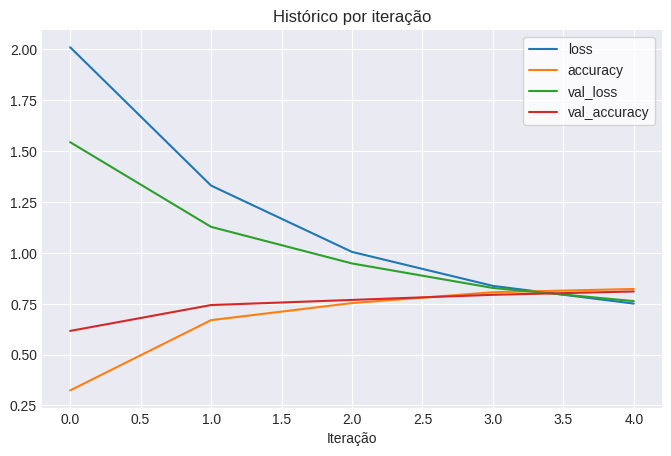

94668760/94668760 [==============================] - 1s 0us/step
Salvando log TensorBoard em: 'outros_modelos/modelo_resnet50v2/20230125-061144'.
Epoch 1/5
24/24 [==============================] - 345s 15s/step - loss: 62.3682 - accuracy: 0.1173 - val_loss: 41.3101 - val_accuracy: 0.1536
Epoch 2/5
24/24 [==============================] - 403s 17s/step - loss: 30.4756 - accuracy: 0.1573 - val_loss: 32.4427 - val_accuracy: 0.1460
Epoch 3/5
24/24 [==============================] - 399s 17s/step - loss: 28.0665 - accuracy: 0.1560 - val_loss: 18.8574 - val_accuracy: 0.1484
Epoch 4/5
24/24 [==============================] - 338s 15s/step - loss: 19.3775 - accuracy: 0.1693 - val_loss: 23.8133 - val_accuracy: 0.1624
Epoch 5/5
24/24 [==============================] - 338s 15s/step - loss: 22.3610 - accuracy: 0.1707 - val_loss: 22.0111 - val_accuracy: 0.1848


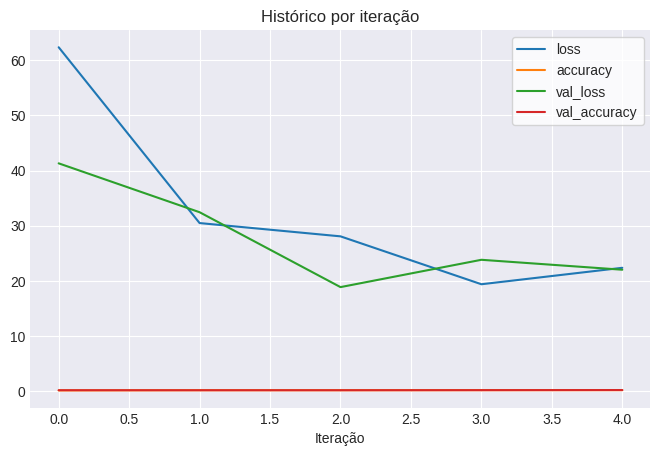

In [10]:
for mb in MODELOS_BASE:
    modelo_base = mb(include_top=False)
    modelo_base.trainable = False

    modelo_nome = f'modelo_{modelo_base.name}'

    entradas = Input(shape=FORMATO_ENTRADA, name='camada_entrada')

    # Há um bug na versão 2.8 do TensorFlow que faz necessário forçar o treinamento para que a expansão dos dados funcione.
    expandidos = expansao_dados(entradas, training=True)

    camadas = modelo_base(expandidos, training=False)
    camadas = GlobalAveragePooling2D(name='agrupamento_media_global')(camadas)

    saidas = Dense(len(rotulos), activation=ATIVACAO, name='camada_saida')(camadas)

    modelo = Model(inputs=entradas, outputs=saidas, name=modelo_nome)

    modelo.compile(loss=PERDA,
                   optimizer=Adam(learning_rate=APRENDIZADO),
                   metrics=METRICAS)
    
    historico = modelo.fit(dados_treino,
                           epochs=ITERACOES,
                           steps_per_epoch=len(dados_treino),
                           validation_data=dados_teste,
                           validation_steps=len(dados_teste),
                           callbacks=[criar_callback_tensorboard(diretorio='outros_modelos', experimento=modelo_nome)],
                           verbose=1)
    
    grafico_historico_por_iteracao(historico)
    
    modelo.save(f'{modelo_nome}_HDF5.h5')

## Comparando modelos utilizando TensorBoard

In [11]:
# !tensorboard dev upload --logdir ./outros_modelos/ \
#                         --name "Teste de Modelos." \
#                         --description "Teste de modelos EfficientNet, Inception, ResNet, VGG. Base de dados Food101 reduzida." \
#                         --one_shot

TensorBoard link: 